In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Load the Tecator dataset
file_path = 'tecator.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
tecator_data.head()


850 nm   852 nm   854 nm   856 nm   858 nm   860 nm   862 nm   864 nm  \
0  2.61776  2.61814  2.61859  2.61912  2.61981  2.62071  2.62186  2.62334   
1  2.83454  2.83871  2.84283  2.84705  2.85138  2.85587  2.86060  2.86566   
2  2.58284  2.58458  2.58629  2.58808  2.58996  2.59192  2.59401  2.59627   
3  2.82286  2.82460  2.82630  2.82814  2.83001  2.83192  2.83392  2.83606   
4  2.78813  2.78989  2.79167  2.79350  2.79538  2.79746  2.79984  2.80254   

    866 nm   868 nm  ...  1038 nm  1040 nm  1042 nm  1044 nm  1046 nm  \
0  2.62511  2.62722  ...  2.94013  2.91978  2.89966  2.87964  2.85960   
1  2.87093  2.87661  ...  3.26655  3.25369  3.24045  3.22659  3.21181   
2  2.59873  2.60131  ...  2.65112  2.63262  2.61461  2.59718  2.58034   
3  2.83842  2.84097  ...  2.92576  2.90251  2.87988  2.85794  2.83672   
4  2.80553  2.80890  ...  3.25831  3.23784  3.21765  3.19766  3.17770   

   1048 nm  1050 nm   fat  water  protein  
0  2.83940  2.81920  22.5   60.5     16.7  
1  3.19600  3.17942  40.1   46.0     13.5  
2  2.56404  2.54816   8.4   71.0     20.5  
3  2.81617  2.79622   5.9   72.8     20.7  
4  3.15770  3.13753  25.5   58.3     15.5  

[5 rows x 103 columns]

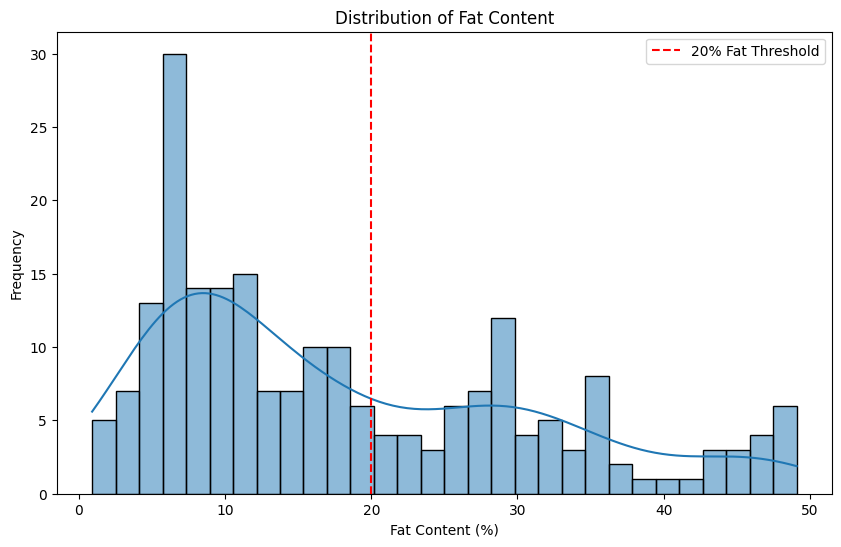

count    215.000000
mean      18.142326
std       12.740297
min        0.900000
25%        7.300000
50%       14.000000
75%       28.000000
max       49.100000
Name: fat, dtype: float64

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Summary statistics of the fat content
fat_summary = tecator_data['fat'].describe()

# Distribution of fat content
plt.figure(figsize=(10, 6))
sns.histplot(tecator_data['fat'], bins=30, kde=True)
plt.axvline(x=20, color='red', linestyle='--', label='20% Fat Threshold')
plt.title('Distribution of Fat Content')
plt.xlabel('Fat Content (%)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Display the summary statistics of fat content
fat_summary


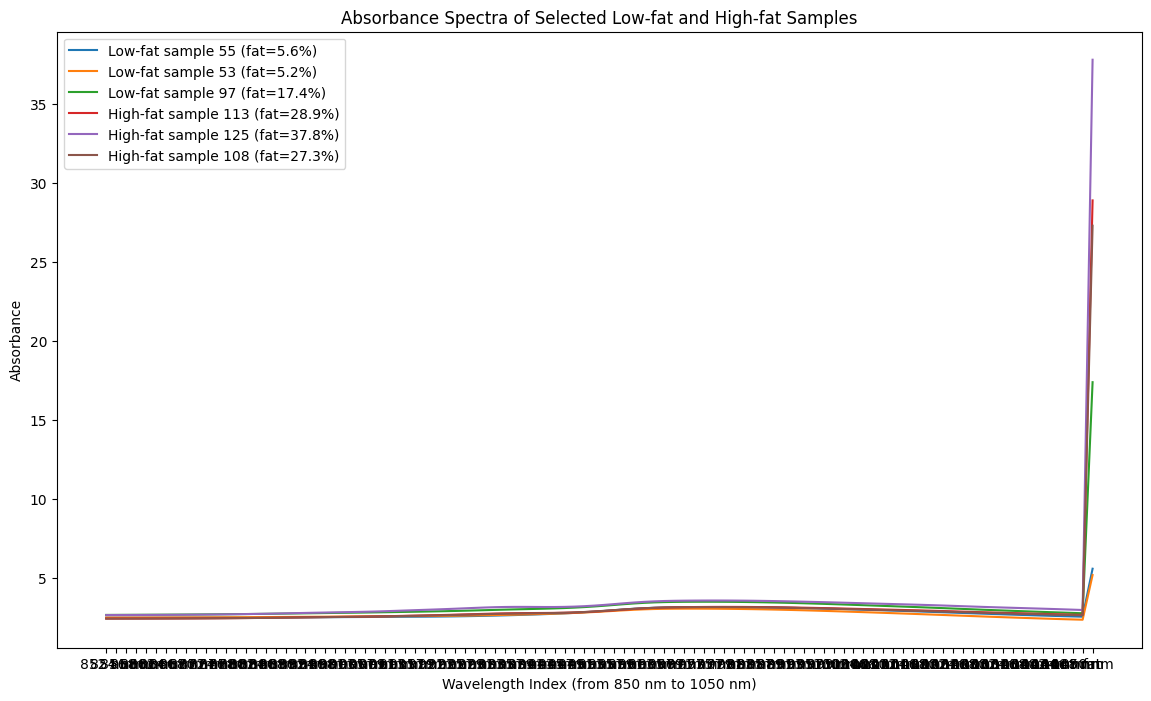

In [20]:
# Plot absorbance spectra for a few samples with different fat contents
plt.figure(figsize=(14, 8))

# Select samples with low and high fat content
low_fat_samples = tecator_data[tecator_data['fat'] <= 20].sample(3, random_state=1)
high_fat_samples = tecator_data[tecator_data['fat'] > 20].sample(3, random_state=1)

# Plot low-fat samples
for idx, row in low_fat_samples.iterrows():
    plt.plot(row[1:101], label=f'Low-fat sample {idx} (fat={row["fat"]}%)')

# Plot high-fat samples
for idx, row in high_fat_samples.iterrows():
    plt.plot(row[1:101], label=f'High-fat sample {idx} (fat={row["fat"]}%)')

plt.title('Absorbance Spectra of Selected Low-fat and High-fat Samples')
plt.xlabel('Wavelength Index (from 850 nm to 1050 nm)')
plt.ylabel('Absorbance')
plt.legend()
plt.show()


In [21]:
data['fat_category'] = data['fat'].apply(lambda x: 0 if x <= 20 else 1)

# Drop unnecessary columns
X = data.drop(columns=['fat', 'water', 'protein', 'fat_category'])
y = data['fat_category']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define a function to evaluate different classifiers with cross-validation
def evaluate_classifiers(X, y):
    classifiers = {
        'Logistic Regression': LogisticRegression(max_iter=10000),
        'SVM': SVC(),
        'Random Forest': RandomForestClassifier(),
        'KNN': KNeighborsClassifier()
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for name, clf in classifiers.items():
        cv_scores = cross_val_score(clf, X, y, cv=kf, scoring='accuracy')
        print(f'{name} CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}')

# Evaluate classifiers
evaluate_classifiers(X_scaled, y)

# Hyperparameter tuning using GridSearchCV
param_grid_lr = {
    'C': [0.1, 1, 10, 100]
}

param_grid_svc = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001]
}

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30]
}

param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9]
}

classifiers = {
    'Logistic Regression': (LogisticRegression(max_iter=10000), param_grid_lr),
    'SVM': (SVC(), param_grid_svc),
    'Random Forest': (RandomForestClassifier(), param_grid_rf),
    'KNN': (KNeighborsClassifier(), param_grid_knn)
}

best_estimators = {}
for name, (clf, param_grid) in classifiers.items():
    grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_scaled, y)
    best_estimators[name] = grid_search.best_estimator_
    print(f'{name} Best Params: {grid_search.best_params_}')
    print(f'{name} Best CV Accuracy: {grid_search.best_score_:.4f}')

# Select the best model based on cross-validation score
best_model_name = max(best_estimators, key=lambda name: cross_val_score(best_estimators[name], X_scaled, y, cv=5).mean())
best_model = best_estimators[best_model_name]

# Evaluate the best model with cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_model, X_scaled, y, cv=kf, scoring='accuracy')
print(f'Best Model ({best_model_name}) CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}')

# Final evaluation on the test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Best Model ({best_model_name}) Test Accuracy: {accuracy:.4f}')

Logistic Regression CV Accuracy: 0.9535 ± 0.0208
SVM CV Accuracy: 0.7116 ± 0.0814
Random Forest CV Accuracy: 0.8233 ± 0.0479
KNN CV Accuracy: 0.7721 ± 0.0426
Logistic Regression Best Params: {'C': 10}
Logistic Regression Best CV Accuracy: 0.9767
SVM Best Params: {'C': 100, 'gamma': 0.01}
SVM Best CV Accuracy: 0.9488
Random Forest Best Params: {'max_depth': 10, 'n_estimators': 50}
Random Forest Best CV Accuracy: 0.8233
KNN Best Params: {'n_neighbors': 3}
KNN Best CV Accuracy: 0.7814
Best Model (Logistic Regression) CV Accuracy: 0.9721 ± 0.0174
Best Model (Logistic Regression) Test Accuracy: 0.9767
